# 안쓰는 것

## 서비스 계정 키 설정

In [1]:
import glob

from google.cloud import bigquery
from google.oauth2 import service_account

# 서비스 계정 키 JSON 파일 경로
key_path = glob.glob("F:/스파르타강의/프로젝트 데이터/실전프로젝트/config/*.json")[0]

# Credentials 객체 생성
credentials = service_account.Credentials.from_service_account_file(key_path)

## 빅쿼리 클라이언트 정의

In [2]:
# GCP 클라이언트 객체 생성
client = bigquery.Client(credentials = credentials, 
                         project = credentials.project_id)

# 데이터 불러오기

In [1]:
import pandas as pd
import yfinance as yf
start = '2021-01-01'
end = '2023-12-31'
symbol = 'AAPL' # "005930.KS"
df = yf.download(symbol, start, end)
df = df.rename(columns={'Adj Close': 'Adj_Close'})
df['ds'] = pd.to_datetime(df.index, format = '%Y-%m-%d') # 굳이 넣어야하나 고민중
df['y'] = df['Close'] # 마찬가지로 굳이 넣어야하나 고민중
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume,ds,y
Date,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002121,143301900,2021-01-04,129.410004
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572327,97664900,2021-01-05,131.009995
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244377,155088000,2021-01-06,126.599998


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2021-01-04 to 2023-12-29
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Open       753 non-null    float64       
 1   High       753 non-null    float64       
 2   Low        753 non-null    float64       
 3   Close      753 non-null    float64       
 4   Adj_Close  753 non-null    float64       
 5   Volume     753 non-null    int64         
 6   ds         753 non-null    datetime64[ns]
 7   y          753 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 52.9 KB


In [3]:
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

,ds,y
Date,,
2021-01-04,2021-01-04,129.410004
2021-01-05,2021-01-05,131.009995
2021-01-06,2021-01-06,126.599998
2021-01-07,2021-01-07,130.919998
2021-01-08,2021-01-08,132.050003
...,...,...
2023-12-22,2023-12-22,193.600006
2023-12-26,2023-12-26,193.050003
2023-12-27,2023-12-27,193.149994


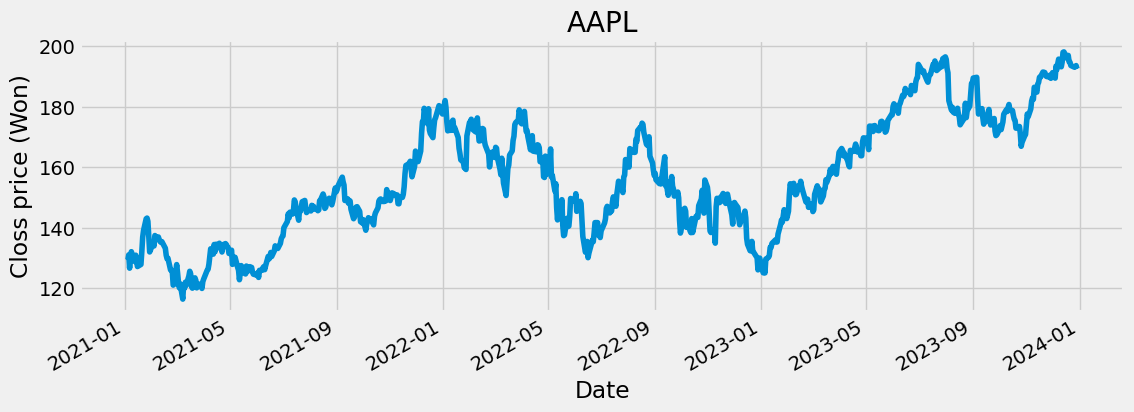

In [4]:
df_input = df[['ds','y']]
display(df_input)
ax = df_input['y'].plot(title = symbol, figsize =(12,4))
ax.set_ylabel('Closs price (Won)')
plt.show()

In [5]:
model_prophet = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True)
model_prophet.fit(df_input)

10:00:32 - cmdstanpy - INFO - Chain [1] start processing
10:00:32 - cmdstanpy - INFO - Chain [1] done processing


예측하기 위한 날짜 생성

In [6]:
fcast_time = 365 # 365일 예측
freq_option = 'D'
future = model_prophet.make_future_dataframe(periods = fcast_time, freq = freq_option)
future.tail(10)

,ds
1108,2024-12-19
1109,2024-12-20
1110,2024-12-21
1111,2024-12-22
1112,2024-12-23
1113,2024-12-24
1114,2024-12-25
1115,2024-12-26
1116,2024-12-27
1117,2024-12-28


In [7]:
from workalendar.usa import UnitedStates
# AAPL의 경우 미국 거래소에서 거래가 이루어지니 미국 공휴일 정보 가져와서 리스트로 만드는 과정
# cal = workalendar.usa.UnitedStates()
cal = UnitedStates()
holiday_dates = []

for year in range(2021, 2025):  # 2021년부터 2024년까지
    holiday_dates.extend([date for date, _ in cal.holidays(year)])

In [8]:
future = future[future['ds'].dt.dayofweek < 5] # 주말 제외 작업
future = future[~future['ds'].isin(holiday_dates)] # 공휴일 제외 작업

In [9]:
df_forecast = model_prophet.predict(future)
df_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
991,2024-12-20,208.399744,42.202033,367.224300
992,2024-12-23,208.497468,42.220717,371.747792
993,2024-12-24,208.480149,39.797701,373.641023
994,2024-12-26,208.297338,42.135128,372.707398
995,2024-12-27,208.379444,38.918495,375.461734


In [ ]:
# model_prophet.plot(df_forecast, xlabel = 'Date',ylabel ='price($)')
# model_prophet.plot_components(df_forecast);

In [1]:
# import pandas as pd
# df = pd.read_csv('predict_aapl_2021-01-01to2023-12-31_to365days.csv')
# df.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,125.837293,127.996858,138.752594,125.837293,125.837293,7.130274,7.130274,7.130274,2.360639,...,0.160907,0.160907,0.160907,4.608728,4.608728,4.608728,0.0,0.0,0.0,132.967567
1,2021-01-05,125.788028,126.745361,138.011724,125.788028,125.788028,6.900233,6.900233,6.900233,2.360639,...,0.143280,0.143280,0.143280,4.396314,4.396314,4.396314,0.0,0.0,0.0,132.688260
2,2021-01-06,125.738762,127.256342,138.141318,125.738762,125.738762,6.693765,6.693765,6.693765,2.360639,...,0.150670,0.150670,0.150670,4.182456,4.182456,4.182456,0.0,0.0,0.0,132.432527


In [6]:
# df.info() # 데이터 타입 확인하고 변경해주기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ds                          1010 non-null   object 
 1   trend                       1010 non-null   float64
 2   yhat_lower                  1010 non-null   float64
 3   yhat_upper                  1010 non-null   float64
 4   trend_lower                 1010 non-null   float64
 5   trend_upper                 1010 non-null   float64
 6   additive_terms              1010 non-null   float64
 7   additive_terms_lower        1010 non-null   float64
 8   additive_terms_upper        1010 non-null   float64
 9   daily                       1010 non-null   float64
 10  daily_lower                 1010 non-null   float64
 11  daily_upper                 1010 non-null   float64
 12  weekly                      1010 non-null   float64
 13  weekly_lower                1010 

밑에 실행하기 전에 df의 형식 확인하고 변경해주기

In [13]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

# BigQuery 클라이언트 생성
client = bigquery.Client()
project_id = client.project #'actual-project-415811'

### 여기 설정 ###
dataset_name = 'stockdata' # 여기 부분 원하는 데이터셋으로 설정
### 여기 설정 끝 ###

# 데이터 세트 ID 설정. 이 ID는 '[YOUR_PROJECT_ID].[DATASET_ID]' 형식이어야 합니다.
dataset_id = "{}.{}".format(project_id, dataset_name)

# 데이터 세트 참조 생성
dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

try:
    # 데이터 세트가 존재하는지 확인
    client.get_dataset(dataset_ref)
    print("Dataset already exists.")
except NotFound:
    # 데이터 세트가 존재하지 않으면, 데이터 세트 생성
    dataset = bigquery.Dataset(dataset_id) # 데이터 세트 설정
    dataset.location = "asia-northeast3" # 데이터 세트의 지역을 설정(서울로 설정)
    dataset = client.create_dataset(dataset)  # API request # 데이터 세트 생성
    print("Created dataset {}.{}".format(project_id, dataset.dataset_id))

# client = bigquery.Client()
# dataset = 'stockdata' 

### 여기 설정 ###
table_name = 'aapl_2021-01-01to2023-12-31' # 'predict_aapl_2021-01-01to2023-12-31_to365days'
### 여기 설정 끝 ###

table_id = "{}.{}".format(dataset_name,table_name)
df.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')

Dataset already exists.


100%|██████████| 1/1 [00:00<?, ?it/s]


In [15]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

# BigQuery 클라이언트 생성
client = bigquery.Client()
project_id = client.project #'actual-project-415811'

### 여기 설정 ###
dataset_name = 'stockdata' # 여기 부분 원하는 데이터셋으로 설정
### 여기 설정 끝 ###

# 데이터 세트 ID 설정. 이 ID는 '[YOUR_PROJECT_ID].[DATASET_ID]' 형식이어야 합니다.
dataset_id = "{}.{}".format(project_id, dataset_name)

# 데이터 세트 참조 생성
dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

try:
    # 데이터 세트가 존재하는지 확인
    client.get_dataset(dataset_ref)
    print("Dataset already exists.")
except NotFound:
    # 데이터 세트가 존재하지 않으면, 데이터 세트 생성
    dataset = bigquery.Dataset(dataset_id) # 데이터 세트 설정
    dataset.location = "asia-northeast3" # 데이터 세트의 지역을 설정(서울로 설정)
    dataset = client.create_dataset(dataset)  # API request # 데이터 세트 생성
    print("Created dataset {}.{}".format(project_id, dataset.dataset_id))

# client = bigquery.Client()
# dataset = 'stockdata' 

### 여기 설정 ###
table_name = 'predict_aapl_2021-01-01to2023-12-31_to365days'
### 여기 설정 끝 ###

table_id = "{}.{}".format(dataset_name,table_name)
df_forecast.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')

Dataset already exists.


100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
def Load_data_in_google_bigquery(df:pd.DataFrame, table_name:str, dataset_name:str='stockdata', if_exists_option:str='replace'):
    from google.cloud import bigquery
    from google.cloud.exceptions import NotFound

    # BigQuery 클라이언트 생성
    client = bigquery.Client()
    project_id = client.project #'actual-project-415811'

    ### 여기 설정 ###
    # dataset_name = 'stockdata' # 여기 부분 원하는 데이터셋으로 설정
    # table_name = 'predict_aapl_2021-01-01to2023-12-31_to365days'
    ### 여기 설정 끝 ###

    # 데이터 세트 ID 설정. 이 ID는 '[YOUR_PROJECT_ID].[DATASET_ID]' 형식이어야 합니다.
    dataset_id = "{}.{}".format(project_id, dataset_name)

    # 데이터 세트 참조 생성
    dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

    try:
        # 데이터 세트가 존재하는지 확인
        client.get_dataset(dataset_ref)
        print("Dataset already exists.")
    except NotFound:
        # 데이터 세트가 존재하지 않으면, 데이터 세트 생성
        dataset = bigquery.Dataset(dataset_id) # 데이터 세트 설정
        dataset.location = "asia-northeast3" # 데이터 세트의 지역을 설정(서울로 설정)
        dataset = client.create_dataset(dataset)  # API request # 데이터 세트 생성
        print("Created dataset {}.{}".format(project_id, dataset.dataset_id))

    # client = bigquery.Client()
    # dataset = 'stockdata' 

    table_id = "{}.{}".format(dataset_name,table_name)
    df.to_gbq(destination_table=table_id, project_id=project_id, if_exists=if_exists_option)

In [ ]:
# table_name = 'predict_aapl_2021-01-01to2023-12-31_to365days'
def Automatically_create_table_names(predict_status:bool=False) -> str:
    if freq_option == 'D': # 후에 딕셔너리 만들어줄까 고민중
        datetime = 'days'
        
    if predict_status == False:
        etc='predict_' #''
        table_name = f'{etc}{symbol}_{start}to{end}_to{str(fcast_time)}{datetime}'
    else:
        table_name = f'{symbol}_{start}to{end}'
    return table_name

In [ ]:
table_name = Automatically_create_table_names()
Load_data_in_google_bigquery(df, table_name=table_name)

In [10]:
start_r = '2024-01-01'
end_r = '2024-02-29'
ticker_r = 'AAPL'

df_recent = yf.download(ticker_r, start=start_r, end=end_r)
df_recent['ds'] = pd.to_datetime(df_recent.index, format = '%Y-%m-%d')
df_recent['y'] = df_recent['Close']
display(df_recent.head(3))

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ds,y
Date,,,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,2024-01-02,185.639999
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500,2024-01-03,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600,2024-01-04,181.910004


In [16]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

# BigQuery 클라이언트 생성
client = bigquery.Client()
project_id = client.project #'actual-project-415811'

### 여기 설정 ###
dataset_name = 'stockdata' # 여기 부분 원하는 데이터셋으로 설정
### 여기 설정 끝 ###

# 데이터 세트 ID 설정. 이 ID는 '[YOUR_PROJECT_ID].[DATASET_ID]' 형식이어야 합니다.
dataset_id = "{}.{}".format(project_id, dataset_name)

# 데이터 세트 참조 생성
dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

try:
    # 데이터 세트가 존재하는지 확인
    client.get_dataset(dataset_ref)
    print("Dataset already exists.")
except NotFound:
    # 데이터 세트가 존재하지 않으면, 데이터 세트 생성
    dataset = bigquery.Dataset(dataset_id) # 데이터 세트 설정
    dataset.location = "asia-northeast3" # 데이터 세트의 지역을 설정(서울로 설정)
    dataset = client.create_dataset(dataset)  # API request # 데이터 세트 생성
    print("Created dataset {}.{}".format(project_id, dataset.dataset_id))

# client = bigquery.Client()
# dataset = 'stockdata' 

### 여기 설정 ###
table_name = 'aapl_2024-01-01to2024-02-29' # 'predict_aapl_2021-01-01to2023-12-31_to365days'
### 여기 설정 끝 ###

table_id = "{}.{}".format(dataset_name,table_name)
df_recent.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')

Dataset already exists.


100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


In [11]:
test_data = df_recent['y']
fc = df_forecast[df_forecast['ds']>='2024-01-01'].iloc[:len(test_data)]['yhat']

test_data = test_data.reset_index(drop=True)
fc = fc.reset_index(drop=True)

In [12]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)
mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)
mape = mean_absolute_percentage_error(test_data, fc)
print('MAPE: ' , '{:.2f}%'.format(mape*100))

MSE:  89.61760808516308
MAE:  8.566209109590414
RMSE:  9.466657704024325
MAPE:  4.63%


In [13]:
metrics = pd.DataFrame(
    {
    'MSE': [mse],
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE_percentage': [mape*100]
    }
)

In [14]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

# BigQuery 클라이언트 생성
client = bigquery.Client()
project_id = client.project #'actual-project-415811'

### 여기 설정 ###
dataset_name = 'predict_metrics' # 여기 부분 원하는 데이터셋으로 설정
### 여기 설정 끝 ###

# 데이터 세트 ID 설정. 이 ID는 '[YOUR_PROJECT_ID].[DATASET_ID]' 형식이어야 합니다.
dataset_id = "{}.{}".format(project_id, dataset_name)

# 데이터 세트 참조 생성
dataset_ref = bigquery.DatasetReference.from_string(dataset_id)

try:
    # 데이터 세트가 존재하는지 확인
    client.get_dataset(dataset_ref)
    print("Dataset already exists.")
except NotFound:
    # 데이터 세트가 존재하지 않으면, 데이터 세트 생성
    dataset = bigquery.Dataset(dataset_id) # 데이터 세트 설정
    dataset.location = "asia-northeast3" # 데이터 세트의 지역을 설정(서울로 설정)
    dataset = client.create_dataset(dataset)  # API request # 데이터 세트 생성
    print("Created dataset {}.{}".format(project_id, dataset.dataset_id))

# client = bigquery.Client()
# dataset = 'stockdata' 

### 여기 설정 ###
table_name = 'metrics_prophet_aapl_2024-01-01to2024-02-29' # 'predict_aapl_2021-01-01to2023-12-31_to365days'
### 여기 설정 끝 ###

table_id = "{}.{}".format(dataset_name,table_name)
metrics.to_gbq(destination_table=table_id, project_id=project_id, if_exists='replace')

Created dataset actual-project-415811.predict_metrics


100%|██████████| 1/1 [00:00<?, ?it/s]
